# Descripción del sistema de ANC usando ML
Siguiendo: Deep ANC: A deep learning approach to active noise control (Neural Networks 141 (2021) 1–10)

In [1]:
import numpy as np
import pyroomacoustics as pra  # usamos paquete pyroomacoustics para generar RIR de salas
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from scipy import signal
from scipy.linalg import solve_toeplitz
from sklearn.model_selection import train_test_split

#%matplotlib ipympl

## 1 Definición de la sala

#### Definición de la sala:

- `room_dim = [3, 4, 2]`: Define las dimensiones de la sala en metros, 3m de ancho, 4m de largo y 2m de alto.
rt60 = [0.15, 0.175, 0.2, 0.225, 0.25]: Define los valores de RT60 (tiempo de reverberación) para diferentes configuraciones de la sala. En este caso, seleccionamos el modelo con rt60 = 0.2 segundos.
Cálculo de la absorción y orden de la sala:

- `e_absorption, max_order = pra.inverse_sabine(rt60[2], room_dim)`: Calcula la absorción de los materiales de la sala y el orden del modelo FIR necesario para simular la acústica de la sala. Utiliza la fórmula de Sabine inversa basada en el tiempo de reverberación y las dimensiones de la sala.

#### Creación de la sala:

- `room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order)`: Crea la sala con las características definidas (dimensiones, absorción, frecuencia de muestreo, y el orden máximo del modelo).
Definición de la fuente de ruido y altavoces:

- Se define una fuente de ruido (`noise_location`) en la sala con coordenadas `[1.5, 1, 1]`, un altavoz secundario `(loudspeaker_location)` en `[1.5, 2.5, 1]`, y un micrófono de control (`mic_location`) en `[1.5, 3, 1]`.
Estos se añaden a la sala mediante las funciones `room.add_source()` y `room.add_microphone_array()`.


#### Generación de la visualización:

- Finalmente, se genera una representación gráfica de la sala con `room.plot()` y se ajustan los límites del gráfico para visualizar la distribución de la sala.

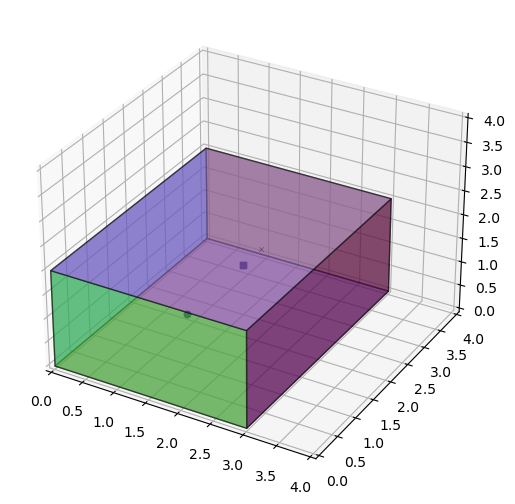

In [2]:
# Dimensiones de la sala (ancho x largo x alto) en metros
room_dim = [3, 4, 2]

# Crear la sala utilizando el método de las imágenes
# rt60 es el tiempo de reverberación objetivo en segundos (RT60)
rt60 = [0.15, 0.175, 0.2, 0.225, 0.25]   # Tiempo de reverberación objetivo en segundos (5 modelos de salas diferentes)

# Creamos sólo modelo de sala de rt60 = 0.2 s
e_absorption, max_order = pra.inverse_sabine(rt60[2], room_dim)  # Obtenemos la absorción de los materiales de las paredes y el orden del modelo FIR necesario 
fs=2000  # En el artículo es 16000, pero para reducir computación lo fijamos a 2000
# Creamos la sala rectangular
room = pra.ShoeBox(
    room_dim,
    fs=fs,                # Frecuencia de muestreo (Hz)
    materials=pra.Material(e_absorption),  # Material con absorción
    max_order=max_order      # Orden máximo del método de imágenes
)


# Añadimos elementos del sistema:
# Fuente de ruido:
noise_location = [1.5, 1, 1]  # Coordenadas de la fuente de ruido
room.add_source(noise_location)


# Altavoz secundario
loudspeaker_location = [1.5, 2.5, 1]  # Coordenadas del altavoz secundario
room.add_source(loudspeaker_location)


# micrófono de control
mic_location = [1.5, 3, 1]  # Coordenadas del micrófono

room.add_microphone_array(pra.MicrophoneArray(np.array([mic_location]).T, room.fs))

# Obtenemos una representación gráfica de la sala
fig, ax = room.plot()
ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_zlim([0, 4]);




### Calcular las respuestas al impulso (RIR)

- `room.compute_rir()`
Aquí estamos calculando las Respuestas al Impulso (RIR) de la sala utilizando el modelo acústico previamente creado. El RIR es una representación de cómo el sonido se propaga desde una fuente hasta el micrófono, teniendo en cuenta los efectos de reflexión, absorción y dispersión en las paredes, techo y suelo de la sala. Este cálculo se realiza usando el método de imágenes.

- `room.rir` es una lista que contiene las RIR para cada micrófono y cada fuente. El índice `[0][0]` se refiere al primer micrófono (el micrófono de control) y a la primera fuente (la fuente de ruido), que representa el camino primario entre la fuente de ruido y el micrófono.

- El índice `[0][1]` se refiere al primer micrófono y a la segunda fuente (el altavoz), lo que representa el camino secundario entre el altavoz y el micrófono


In [3]:
plt.close() # Cerramos el gráfico anterior
# Calcular las respuestas al impulso con sala de pyroomacoustic
room.compute_rir()

# Obtener y visualizar las respuesta al impulso (RIR) de cada canal
p_rir = room.rir[0][0]  # Primer micrófono, Primera fuente (camino primario entre fuente de ruido y micrófono)
s_rir = room.rir[0][1]  # Primer micrófono, Segunda fuente (camino secundario entre altavoz y micrófono)


### Carga de los archivos .mat de MATLAB:
`from scipy.io import loadmat`
- Aquí estamos utilizando la función loadmat de scipy.io para cargar un archivo de datos guardado en formato .mat, que es el formato de MATLAB para guardar matrices y otros tipos de datos.
- Este comando `data = loadmat('rirmatlab.mat')` carga el archivo rirmatlab.mat en el que se almacenan las respuestas al impulso (RIR) generadas en MATLAB. El archivo es un diccionario de Python que contiene las variables almacenadas en MATLAB.
- `data['Pri']` hace referencia a la variable Pri del archivo .mat, que corresponde a la respuesta al impulso del camino primario (fuente de ruido → micrófono).
- `data['Sec']` hace referencia a la variable Sec, que corresponde a la respuesta al impulso del camino secundario (altavoz → micrófono).
- `.flatten()` convierte las matrices de respuesta al impulso en vectores unidimensionales para facilitar su procesamiento y análisis en Python.

In [4]:
# Obtenerlas con rirsimulator de Matlab (usando fs=16000)
from scipy.io import loadmat
data = loadmat('rirmatlab.mat')
p_rir_mat = (data['Pri']).flatten()
s_rir_mat = (data['Sec']).flatten()


## Resultado esperado:

El resultado de este código es una figura con 4 subgráficos donde:
- El primer subgráfico muestra la respuesta al impulso del camino primario (ruido directo) de `pyroomacoustics`.
- El segundo subgráfico muestra la respuesta al impulso del camino secundario (altavoz) de `pyroomacoustics`.
- El tercer subgráfico muestra la respuesta al impulso del camino primario de MATLAB.
- El cuarto subgráfico muestra la respuesta al impulso del camino secundario de MATLAB.


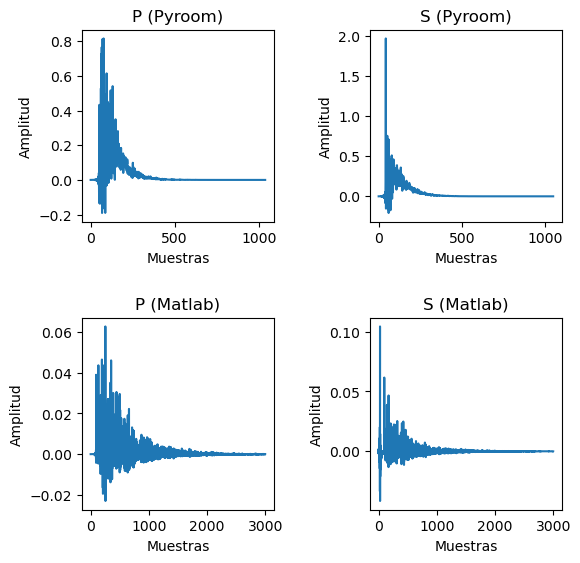

In [5]:
# Representamos gráficamente la respuesta al impulso

plt.figure(figsize=(6,6))

# Ajustar los márgenes y el espacio entre subplots
plt.subplots_adjust(
    left=0.1,   # Margen izquierdo
    right=0.9,  # Margen derecho
    top=0.9,    # Margen superior
    bottom=0.1, # Margen inferior
    wspace=0.5, # Espacio horizontal entre subplots
    hspace=0.5  # Espacio vertical entre subplots
)
plt.subplot(2,2,1)
plt.plot(p_rir)
plt.title("P (Pyroom)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")

plt.subplot(2,2,2)
plt.plot(s_rir)
plt.title("S (Pyroom)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")

plt.subplot(2,2,3)
plt.plot(p_rir_mat)
plt.title("P (Matlab)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")

plt.subplot(2,2,4)
plt.plot(s_rir_mat)
plt.title("S (Matlab)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud");


Limitamos la duración de las RIR hasta donde hay energía significativa

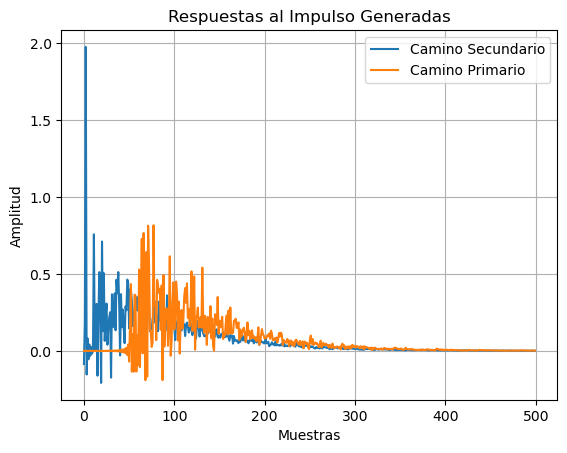

In [6]:
plt.close()
#Podemos modelar las RIR con 500 muestras (para ahorrar computación):
p_rir=p_rir[0:500]
s_rir=s_rir[41:541] #Quitamos retardo inicial

plt.figure()
plt.plot(s_rir)
plt.plot(p_rir)
plt.title("Respuestas al Impulso Generadas")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend(['Camino Secundario', 'Camino Primario'])
plt.grid()

### Generación de la señal de entrada (ruido):

- Se genera una señal de ruido blanco `x` de longitud `N`, donde `N = fs * 10` (esto equivale a 10 segundos de señal, dado que fs es la frecuencia de muestreo).
- La función `np.random.randn(N)` genera una serie de números aleatorios distribuidos normalmente (media cero y varianza uno)

### Aplicación de la respuesta al impulso del camino primario:

`d = signal.lfilter(p_rir, np.array([1]), x)`
- Se utiliza la función `lfilter` de `scipy.signal` para filtrar la señal de ruido x con la respuesta al impulso p_rir (camino primario).
- `lfilter(p_rir, np.array([1]), x)` aplica el filtro FIR definido por p_rir sobre x, simulando cómo el ruido se recibiría en el micrófono de error.
- El resultado es la señal `d`, que representa el ruido recibido por el micrófono debido al camino primario (es decir, el ruido que llega directamente desde la fuente al micrófono).

### Aplicación de la respuesta al impulso del camino secundario:

`xf = signal.lfilter(s_rir, 1, x)`
- Se aplica un segundo filtro usando `lfilter`, pero en este caso se filtra la señal de ruido x con la respuesta al impulso `s_rir` (camino secundario).
- `lfilter(s_rir, 1, x)` filtra la señal x usando el filtro FIR definido por s_rir, simulando cómo el altavoz secundario (u otra fuente de sonido) contribuye a la señal de referencia.
- El resultado es la señal xf, que representa la señal filtrada por el camino secundario.

In [7]:
# Generamos señales
plt.close()
import random
from scipy import signal
from scipy import fft

N=fs*10
x = np.random.randn(N)


d = signal.lfilter(p_rir,np.array([1]),x) # Obtenemos el ruido que habría en el sensor de error
xf = signal.lfilter(s_rir,1,x) # Obtenemos la señal de referencia filtrada



## Solución teórica (calculada usando el dominio frecuencial)

### División en el dominio de la frecuencia:
- Se divide la FFT de p_rir entre la FFT de s_rir, lo que representa una relación en el dominio de la frecuencia entre los dos caminos acústicos. Esta operación puede ser vista como un intento de cancelación o modelado de la relación entre las señales.
### Transformada Inversa (IFFT):
- fft.ifft(...) toma la inversa de la transformada de Fourier para convertir la señal de vuelta al dominio temporal, obteniendo así una respuesta al impulso en el tiempo que trata de modelar la cancelación entre los dos caminos acústicos.
### Problema de Circularidad:
El problema de circularidad puede surgir cuando se utiliza FFT para procesar señales de longitud finita, ya que la FFT supone que la señal es periódica. Esto puede generar efectos indeseados de "envolvimiento" o aliasing en las respuestas al impulso, especialmente si las señales no están alineadas o si las longitudes de las señales no coinciden adecuadamente.

En este caso, la longitud de las FFTs se ha fijado a 8092 muestras, lo que podría ser un intento de manejar la longitud de la respuesta al impulso de manera eficiente, pero es importante tener en cuenta que el envolvimiento circular puede distorsionar el resultado si no se maneja correctamente (por ejemplo, si las señales tienen diferentes longitudes).

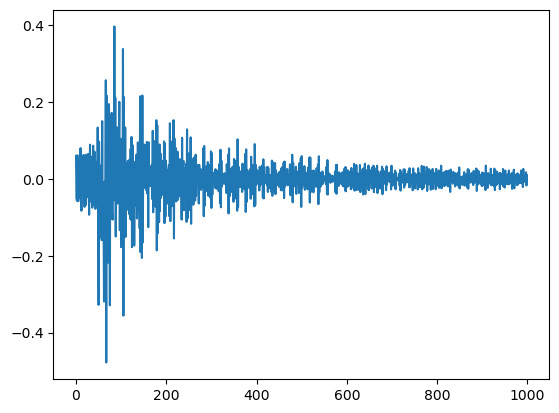

In [8]:
# usando FFT (tenemos problema de circularidad)
W=np.real(fft.ifft(-fft.fft(p_rir,8092)/fft.fft(s_rir,8092)))

plt.figure()
plt.plot(np.real(W[0:1000]));


## Solución de mínimos cuadrados

### Cálculo de la función de autocorrelación de la señal de referencia:
`rxf = signal.correlate(xf, xf) / N`
- `signal.correlate(xf, xf)` calcula la autocorrelación de la señal de referencia `xf`. La autocorrelación mide la similitud entre una señal y una versión desplazada de sí misma, lo cual es útil para caracterizar la estructura temporal de la señal.
- El resultado se normaliza dividiendo por `N` para obtener un valor promedio.

### Cálculo de la función de correlación entre la señal de error y la señal de referencia:
`rxd = signal.correlate(d, xf) / N`
- `signal.correlate(d, xf)` calcula la correlación cruzada entre la señal de error `d` (ruido filtrado por el camino primario) y la señal de referencia `xf`. Esta correlación mide la similitud entre estas dos señales, lo cual es esencial para el diseño del filtro adaptativo.

### Selección de una porción de las correlaciones:
`rxf_ = rxf[N-1:N-1+P]`

`rxd_ = rxd[N-1:N-1+P]`
- `rxf_` y `rxd_` seleccionan las primeras P muestras de las funciones de correlación, donde `P = 1000` es el orden del filtro que se está diseñando. Esto define el tamaño del filtro óptimo.

### Cálculo del filtro óptimo `w0`:
`w0 = -solve_toeplitz(rxf_, rxd_)`
- La función `solve_toeplitz` resuelve un sistema de ecuaciones lineales basado en la matriz Toeplitz formada por la autocorrelación `rxf_` y la correlación cruzada `rxd_`. El resultado es el filtro óptimo `w0`, que minimiza el error en el sistema de cancelación de ruido.
- El signo negativo se utiliza porque estamos tratando de cancelar el ruido, es decir, el filtro debe tener una respuesta opuesta a la señal de referencia.

### Resultado esperado:

- Filtro Óptimo: El gráfico de `w0` muestra cómo debería ser la respuesta del filtro que minimiza el ruido en el micrófono de error. Este filtro se utilizará para la cancelación activa de ruido (ANC), de modo que el ruido que llega al micrófono de error se vea compensado por la señal de referencia filtrada.

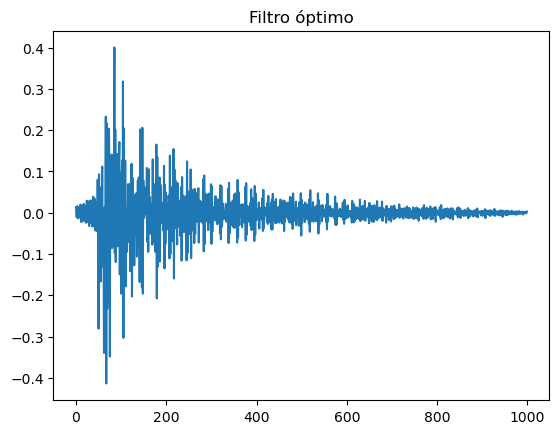

In [9]:
plt.close()


P = 1000 # Orden del modelo 
rxf = signal.correlate(xf,xf)/N
rxf_ = rxf[N-1:N-1+P]

rxd = signal.correlate(d,xf)/N
rxd_ = rxd[N-1:N-1+P]

w0 = -solve_toeplitz(rxf_,rxd_)
plt.figure()
plt.plot(w0)
plt.title('Filtro óptimo');



### Filtrado de la señal de referencia con el filtro óptimo:
`y = signal.lfilter(w0, 1, x)`
- `signal.lfilter(w0, 1, x)` aplica el filtro óptimo `w0` a la señal de referencia `x`. El filtro óptimo fue calculado previamente para minimizar el error entre la señal de referencia y la señal de error.
- El resultado y es la señal filtrada que se utilizará como la señal de salida que se enviará al altavoz secundario.
### Propagación de la señal filtrada a través del camino acústico:
`yf = signal.lfilter(s_rir, 1, y)`
- `signal.lfilter(s_rir, 1, y)` propaga la señal de salida y a través del camino acústico secundario (usando la respuesta al impulso `s_rir`). Esto simula cómo la señal filtrada es afectada por el entorno acústico (el espacio entre el altavoz y el micrófono).
- El resultado `yf` es la señal que llega al micrófono después de ser propagada por el camino acústico.
### Suma de las señales de error y salida:
`e = d + yf`
- La señal de error `e` es la suma de la señal de ruido filtrado `d` y la señal propagada `yf` a través del camino acústico. Este paso representa el error final después de que la señal filtrada se haya propagado por el entorno acústico.

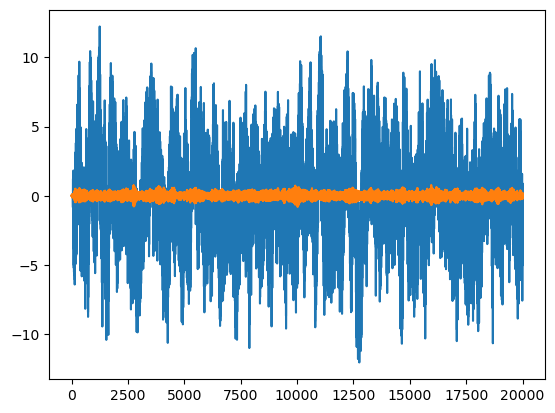

In [10]:
# Visualizamos resultados offline
plt.close()
y = signal.lfilter(w0,1,x)  # Generamos la señal resultado de filtrar la señal de referencia por el filtro óptimo
yf = signal.lfilter(s_rir,1,y) # Propagamos la señal de salida a travén del camino acústico entre el altavoz y el micrófono

e = d + yf
plt.figure()
plt.plot(d)
plt.plot(e);

## Solucion Adaptativa muestra a muestra
Este bloque de código implementa una versión del filtro adaptativo utilizando el algoritmo de LMS (Least Mean Squares) para la cancelación activa de ruido (ANC).
### Inicialización de variables:
- `x_buf`: Un buffer que almacena las últimas muestras de la señal filtrada de referencia.
- `w`: El vector de coeficientes del filtro adaptativo, que se actualiza iterativamente.
- `w_estado`: El estado interno del filtro (utilizado para la implementación del filtro con condiciones iniciales).
- `s_estado` y `estado_propaga`: El estado para la propagación de la señal a través del camino acústico.
- `mu`: El paso de adaptación del filtro. Un valor pequeño que controla la rapidez con la que el filtro se ajusta.
- `delta`: Un pequeño valor para evitar la división por cero al calcular el paso de adaptación.
### Flitrado y adaptación:
Para cada muestra de la señal x[n], se realiza lo siguiente:

#### Adapta:

- Se aplica el filtro adaptativo w sobre la señal de entrada x[n] utilizando signal.lfilter. Esto produce la salida yn y actualiza el estado del filtro (w_estado).
- Luego, se filtra la señal de referencia x[n] a través del camino acústico secundario s_rir para obtener la salida xfn (filtrada), actualizando el estado s_estado.
- El filtro adaptativo se ajusta con el paso de adaptación mun calculado utilizando mu y el error acumulado en. El filtro se actualiza restando el producto de mun, el buffer de entrada x_buf, y el error en.
- El buffer de entrada x_buf se actualiza para almacenar la nueva señal filtrada de referencia xfn.

#### Propaga:

- La salida yn es propagada a través del camino acústico secundario s_rir para obtener la señal yfn, que es la versión propagada de la señal adaptada.
- El error en es calculado como la diferencia entre la señal de referencia d[n] (ruido recibido en el micrófono de error) y la señal propagada yfn.
- 
El proceso de adaptación y propagación se repite para cada muestra n de la señal.


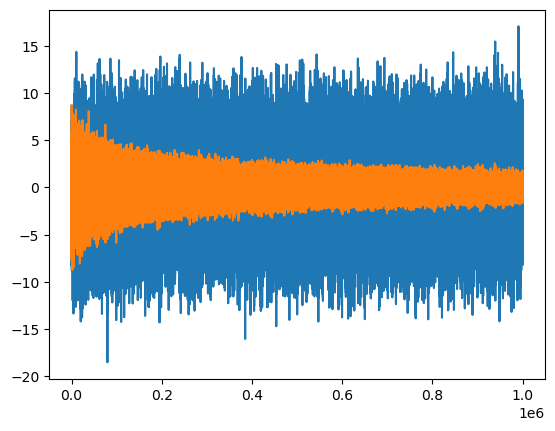

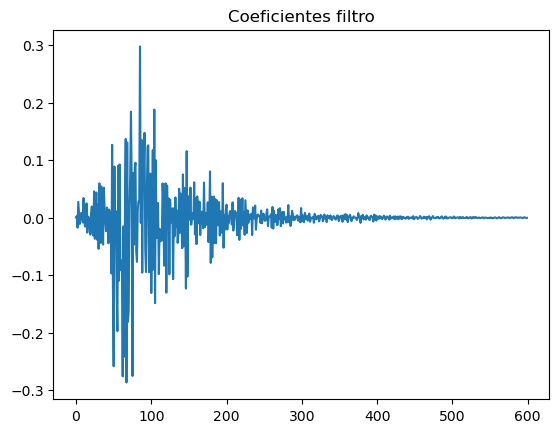

In [22]:
plt.close()

N=fs*500
x = np.random.randn(N)
d = signal.lfilter(p_rir,1,x) # Obtenemos el ruido que habría en el sensor de error
xf = signal.lfilter(s_rir,1,x) # Obtenemos la señal de referencia filtrada

L=600 # Orden del modelo
x_buf = np.zeros(L)
w = np.zeros(L)
w_estado = np.zeros(L-1)
s_estado = np.zeros(s_rir.size-1)
estado_propaga=np.zeros(s_rir.size-1)
en=0.;
ve = np.zeros(N)
mu=0.01
delta=1e-15

for n in range(N):

    #Adapta
    yn, w_estado = signal.lfilter(w,1,[x[n]],zi=w_estado)
    xfn, s_estado = signal.lfilter(s_rir,1,[x[n]],zi=s_estado)
    
    mun=mu/(np.sum(np.square(x_buf))+delta)
    w = w - mun*x_buf*en
    #x_buf = np.concatenate((xfn,x_buf[:-1]))
    x_buf[1:] = x_buf[:-1]
    x_buf[0] = xfn
        
    #Propaga
    yfn,estado_propaga = signal.lfilter(s_rir,1,yn,zi = estado_propaga)
    en = d[n]+yfn
    ve[n]= en

plt.figure()
plt.plot(d)  
plt.plot(ve)
plt.figure()
plt.plot(w)
plt.title('Coeficientes filtro');

    


## Solución ML

### Inicialización de parámetros:

- `np.random.seed(42)`: Se establece una semilla para la generación de números aleatorios, lo que asegura que los resultados sean reproducibles.
- `N = 5000`: Especifica la duración de cada secuencia de datos (en número de muestras).
- `I = 10000`: Especifica el número total de secuencias generadas (en este caso, 10,000 secuencias).
- `L = 600`: Es el número de coeficientes del modelo (tamaño del filtro adaptativo).
- `M = np.size(s_rir)`: Es el número de coeficientes del sistema de propagación (tamaño del filtro `s_rir`).
#### Generación de las señales de entrada `X` (ruido blanco):
`X = np.float32(np.random.randn(I, N, 1))`
- Se generan `I` secuencias de longitud `N` (en este caso, 10,000 secuencias de 5000 muestras), donde cada secuencia es una realización de ruido blanco gaussiano. Este ruido servirá como la señal de entrada para el proceso de filtrado.
### Generación de los targets d:
`d = np.array([signal.lfilter(p_rir, 1, x.flatten()) for x in X])`

`d = np.float32(d.reshape(I, N, 1))`
- Para cada secuencia `x` de entrada en `X`, se filtra a través del filtro `p_rir` para simular la respuesta acústica del sistema (es decir, cómo se propaga el sonido a través de la sala). Esto genera la señal deseada o target `d` para cada secuencia.
- El resultado es un conjunto de señales filtradas, donde cada secuencia `d` es la salida correspondiente a la secuencia de entrada `x` después de ser propagada por el filtro `p_rir`.

###  División en conjuntos de entrenamiento y validación:
`X_train, X_val, y_train, y_val = train_test_split(X, d, test_size=0.2, random_state=42)`

- Se divide el conjunto de datos generado en dos partes:
    - Conjunto de entrenamiento (X_train, y_train): El 80% de las secuencias.
    - Conjunto de validación (X_val, y_val): El 20% restante de las secuencias.
- Esto es útil para entrenar y evaluar el rendimiento del modelo sin sobreajustarse a los datos de entrenamiento.

In [11]:
# Generamos base de datos:
np.random.seed(42)
N = 5000 #-> Duración de cada secuencia
I=10000 # -> Número de secuencias 
L= 600 # -> Número de pesos del modelo
M=np.size(s_rir)  # -> Número de coefecientes del sistema de propagación

# Generación de datos de entrenamiento
X = np.float32(np.random.randn(I, N, 1))  # Predictores o Señales de entrada (ruido blanco) 
d = np.array([signal.lfilter(p_rir,1, x.flatten()) for x in X])  # target
d = np.float32(d.reshape(I,N,1))

# División de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, d, test_size=0.2, random_state=42)


## OPCIÓN 1
- Usamos un modelo sencillo con una capa convolucional 1D, seguida de otra capa convolucional 1D que simula la propagación
- De esta manera aprovechamos la función de pérdidas mse por defecto
- Para inferir habrá que quitar la segunda capa convolucional

In [12]:
# Definimos el modelo
model = Sequential([
    Conv1D(filters=1, kernel_size=L, activation='linear', padding='valid', input_shape=(None, 1), use_bias=False),  # Modelo 'entrenable'
    Conv1D(filters=1, kernel_size=s_rir.size, activation='linear', padding='causal', use_bias=False, trainable=False)  # Sistema de propagación no entrenable
])
# Fijamos los pesos de la segunda capa conforme al sistema de propagación acústica. 
pesos=[s_rir[::-1].reshape(s_rir.size, 1, 1)]
model.layers[1].set_weights(pesos)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 1)           600       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 1)           500       
                                                                 
Total params: 1,100
Trainable params: 600
Non-trainable params: 500
_________________________________________________________________


In [13]:
# compilamos con función de pérdidas por defecto
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# entrenamos el modelo
history=model.fit(X_train,-y_train[:,L-1:],epochs=20, batch_size=128, validation_data=(X_val, -y_val[:,L-1:]))

Epoch 1/20
63/63 [==============================] - 260s 4s/step - loss: 8.8931 - val_loss: 5.2774
Epoch 2/20
63/63 [==============================] - 203s 3s/step - loss: 3.8350 - val_loss: 2.7569
Epoch 3/20
63/63 [==============================] - 198s 3s/step - loss: 2.1790 - val_loss: 1.7232
Epoch 4/20
63/63 [==============================] - 198s 3s/step - loss: 1.4412 - val_loss: 1.2096
Epoch 5/20
63/63 [==============================] - 197s 3s/step - loss: 1.0483 - val_loss: 0.9126
Epoch 6/20
63/63 [==============================] - 197s 3s/step - loss: 0.8093 - val_loss: 0.7220
Epoch 7/20
63/63 [==============================] - 195s 3s/step - loss: 0.6511 - val_loss: 0.5918
Epoch 8/20
63/63 [==============================] - 204s 3s/step - loss: 0.5412 - val_loss: 0.5000
Epoch 9/20
63/63 [==============================] - 197s 3s/step - loss: 0.4626 - val_loss: 0.4333
Epoch 10/20
63/63 [==============================] - 139s 2s/step - loss: 0.4051 - val_loss: 0.3841
Epoch 11/

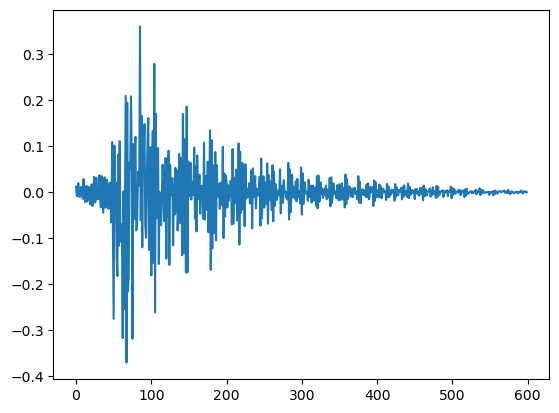

In [15]:
# Visualizamos el modelo que la RN a estimado:
plt.plot(np.array(model.layers[0].weights)[0,::-1,0,0]);

Se crea un nuevo modelo utilizando la Keras API, eliminando la última capa del modelo original. El nuevo modelo toma la misma entrada, pero ahora su salida es la salida de la primera capa convolucional.

Este tipo de manipulación es útil cuando deseas obtener las activaciones de una capa intermedia en lugar de la salida final del modelo. En este caso, la salida será el resultado de aplicar el filtro de la primera capa convolucional sobre los datos de entrada.

In [16]:
# Creamos nuevo modelo para inferir eliminando la última capa
entrada=model.input
salida=model.layers[0].output
new_model=Model(inputs=entrada, outputs=salida)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_input (InputLayer)   [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 1)           600       
                                                                 
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


## Simulación offline

#### Generación de ruido:
- Se crea una señal de ruido blanco de longitud `Ite` (10,000 muestras) utilizando `np.random.randn(Ite)`.
#### Simulación de propagación acústica:
- La señal de ruido es propagada a través del sistema acústico (simulado por la respuesta al impulso `p_rir`) utilizando `signal.lfilter(p_rir, 1, x.flatten())`. Esta es la señal que recibe el sensor de error
#### Predicción utilizando el modelo:
- Se crea una señal de referencia (`xr`) concatenando ceros al principio para dar contexto a la red neuronal y luego se pasa por el modelo entrenado `new_model` para obtener la señal procesada por la red.
#### Simulación de propagación acústica de la señal generada:
- La señal predicha por la red neuronal es propagada a través del sistema acústico utilizando la respuesta al impulso `s_rir`, para simular cómo sonaría la señal procesada por el altavoz después de la propagación.
#### Visualización:
- Se visualizan dos señales en un gráfico:
    - Señal de ruido original (`d1.flatten()`): La señal antes de la cancelación.
    - Señal con cancelación (`d1.flatten() + d1_e.flatten()`): La señal con la cancelación acústica aplicada.

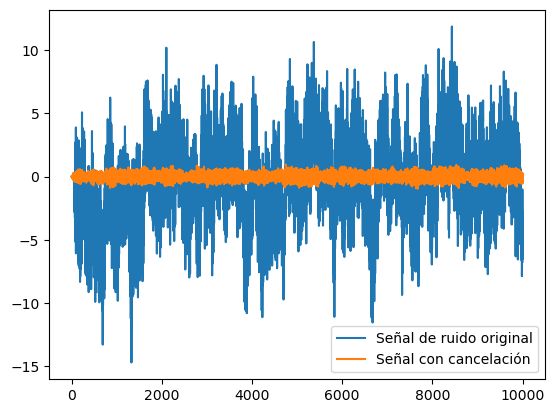

In [17]:
# Comprobamos las prestaciones mediante procesado off-line
Ite=10000 # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(p_rir,1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)

xr = np.concatenate((np.zeros(L-1),x))
y1 = new_model.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
d1_e = signal.lfilter(s_rir,1,y1.flatten())  # Simulamos la propagación acústica de la señal generada 

plt.plot(d1.flatten())   
plt.plot(d1.flatten() + d1_e.flatten())  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);

## Simulación en tiempo real

#### Inicialización de variables:

- `buff_x`: Buffer que almacena las últimas `L` muestras de la señal de entrada.
- `estado_y`: Estado interno del filtro `signal.lfilter` para simular la propagación acústica.
- `e_n`: Vector que almacenará el error (señal resultante tras la cancelación) en cada iteración.

#### Iteración muestra a muestra:

- El buffer `buff_x` se actualiza, desplazando las muestras anteriores y añadiendo la nueva muestra al final.
- El modelo convolucional (`new_model`) procesa el buffer actualizado para generar la señal de salida predicha, `ys`, que es la señal de cancelación estimada.
- La señal de cancelación se propaga a través del sistema acústico (simulado con `s_rir`) usando `signal.lfilter`.
- La señal resultante tras la cancelación, `e_n[n]`, es la suma de la señal de ruido original y la señal generada por el modelo tras la propagación.

#### Se grafican:

- La señal de ruido original (`d1.flatten()`).
- La señal resultante tras la cancelación (`e_n`).

#### El gráfico mostrará dos curvas:

- Señal de ruido original: La referencia del ruido antes de aplicar la cancelación.
- Señal tras cancelación: Una señal atenuada que refleja el efecto del modelo en tiempo real.

Este comportamiento es ideal para verificar cómo el modelo se desempeña en un escenario más realista, donde las señales llegan muestra a muestra.

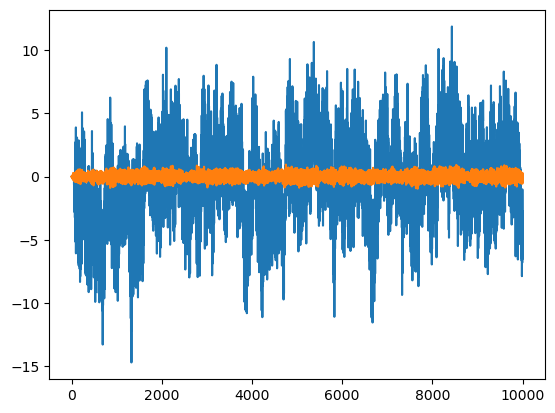

In [18]:
# Creamos simulación Tiempo real (muestra a muestra)

buff_x = np.zeros(L)
estado_y = np.zeros(M-1)
e_n=np.zeros(Ite)
for n in range(Ite):
    #####################################################################################
    #buff_x = np.concatenate((buff_x[1:],[x[n]]))  # La red convolucional procesa los datos considerando la muestra más reciente como la última
    buff_x[0:-1] = buff_x[1:]
    buff_x[-1] = x[n]
    ys = new_model.predict(buff_x.reshape(1,L,1),verbose='False')  #Inferencia de la red
    #####################################################################################
    
    out, estado_y = signal.lfilter(s_rir,1, ys.flatten(), zi = estado_y)  # simulamos propagación acústica
    e_n[n] = d1.flatten()[n] + out  # simulamos suma acústica
plt.plot(d1.flatten())
plt.plot(e_n);

## OPCIÓN 2
- Usamos un modelo sencillo con una capa convolucional 1D
- Hay que redefinir la función de pérdidas teniendo en cuenta la propagación


In [20]:
# Definimos el modelo
# Construcción del modelo CNN 1D
model_custom_loss = Sequential([
    Conv1D(filters=1, kernel_size=L, activation='linear', padding='valid', input_shape=(None, 1), use_bias=False),  
])

model_custom_loss.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 1)           600       
                                                                 
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


#### Preparación del filtro:

- 𝑆: El kernel del sistema secundario (representa la propagación acústica).
- Inversión del filtro (𝑆[::−1]) para adaptarlo a la convolución.
- Transformación del filtro a un tensor 3D compatible con `tf.nn.conv1d`.

#### Filtrado de la salida del modelo:

- La salida predicha (𝑦pred) pasa por una convolución 1D con el filtro 𝑆, simulando la propagación acústica.

#### Ajuste del target (𝑦true):

- Recorta 𝑦true para que tenga el mismo tamaño que la salida filtrada (𝑦pred_filtered), eliminando las primeras 
𝑀 muestras, que corresponden al retardo del sistema.

#### Cálculo del error:

- Se calcula el error cuadrático medio (MSE) entre 𝑦true recortado y la salida filtrada (𝑦pred_filtered).

In [21]:
# Definimos la función de pérdidas personalizada
def custom_loss(S):
    """
    Función de pérdidas personalizada que calcula el MSE entre los targets
    y la salida del modelo filtrada por el camino secunadario S.

    Args:
        filter_kernel (tf.Tensor): Tensor 1D de coeficientes del filtro (longitud P).

    Returns:
        Callable: Función de pérdida para usar en un modelo de Keras.
    """
    M = S.size-1
    # Invertimos los coeficientes para que la convolución se comporte como un filtro lineal 
    filtroinv=np.float32(S[::-1])
    # Expandir dimensiones del filtro para usarlo como kernel en convolución 1D
    filtro_tf = tf.reshape(filtroinv, (-1, 1, 1))
    
    def loss(y_true, y_pred):
        
        # Filtrado directo mediante convolución 1D
        y_pred_filtered = tf.nn.conv1d(
            y_pred, filters=filtro_tf, stride=1, padding="VALID"
        )

        # Ajustar y_true para que coincida con el tamaño de y_pred_filtered
        
        y_true_cropped = y_true[:, M:, :]  # Recortar al principio

        # Calcular el MSE entre los targets y la salida filtrada
        mse = tf.reduce_mean(tf.square(y_true_cropped - y_pred_filtered))
        return mse

    return loss

In [22]:
# Compilamos el modelo con usando la función de pérdidas previamente definida
loss_fn = custom_loss(s_rir)
model_custom_loss.compile(optimizer='adam', loss=loss_fn)

In [23]:
# Entrenamos el modelo
history=model_custom_loss.fit(X_train, -y_train[:,L-1:],epochs=25, batch_size=128, validation_data=(X_val, -y_val[:,L-1:]))

Epoch 1/25
63/63 [==============================] - 91s 1s/step - loss: 6.9116 - val_loss: 3.9942
Epoch 2/25
63/63 [==============================] - 90s 1s/step - loss: 2.8894 - val_loss: 2.0869
Epoch 3/25
63/63 [==============================] - 91s 1s/step - loss: 1.6721 - val_loss: 1.3347
Epoch 4/25
63/63 [==============================] - 90s 1s/step - loss: 1.1243 - val_loss: 0.9416
Epoch 5/25
63/63 [==============================] - 90s 1s/step - loss: 0.8142 - val_loss: 0.6988
Epoch 6/25
63/63 [==============================] - 90s 1s/step - loss: 0.6131 - val_loss: 0.5334
Epoch 7/25
63/63 [==============================] - 89s 1s/step - loss: 0.4725 - val_loss: 0.4151
Epoch 8/25
63/63 [==============================] - 89s 1s/step - loss: 0.3707 - val_loss: 0.3284
Epoch 9/25
63/63 [==============================] - 89s 1s/step - loss: 0.2955 - val_loss: 0.2640
Epoch 10/25
63/63 [==============================] - 89s 1s/step - loss: 0.2393 - val_loss: 0.2156
Epoch 11/25
63/63 [

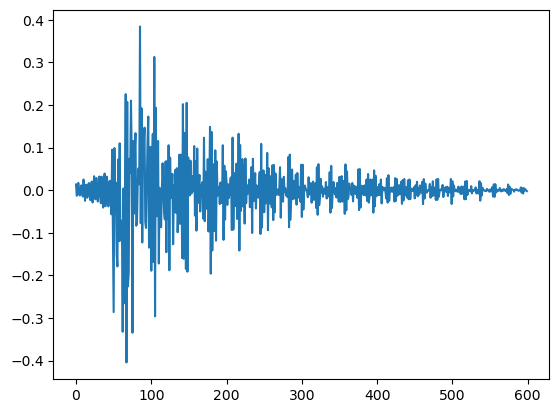

In [24]:
# Visualizamos el modelo que la RN a estimado:
plt.plot(np.array(model_custom_loss.layers[0].weights)[0,::-1,0,0]);

## Simulación offline

#### Generación de Señal de Referencia:

- 𝑥: Señal de ruido (ruido blanco).

#### Simulación del Ruido Original:

- 𝑑1: Señal de ruido generada al pasar 𝑥 a través del sistema primario 𝑝rir.

##### Preprocesamiento:

- 𝑥𝑟: Se añade un padding inicial de 𝐿−1 ceros a 𝑥 para alinearse con el retardo que introduce la capa convolucional.

#### Inferencia con el Modelo:

- 𝑦1: Salida del modelo, representando la señal generada por el altavoz para contrarrestar el ruido.

#### Propagación Secundaria:

- 𝑑1𝑒: Simulación del sistema secundario 𝑠rir aplicado a 𝑦1, para modelar cómo se propaga la señal generada por el altavoz.

#### Visualización:

- Se compara la señal original (𝑑1) con la señal total después de la cancelación (𝑑1+𝑑1𝑒).

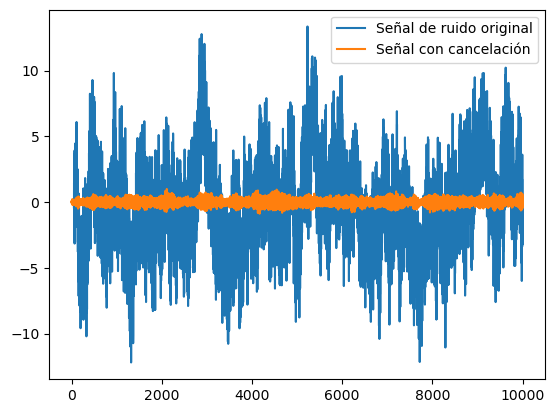

In [25]:
# Comprobamos las prestaciones mediante procesado off-line
Ite=10000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(p_rir,1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)

xr = np.concatenate((np.zeros(L-1),x))
y1 = model_custom_loss.predict(xr.reshape(1,len(xr),1),verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
d1_e = signal.lfilter(s_rir,1,y1.flatten())  # Simulamos la propagación acústica de la señal generada 

plt.plot(d1.flatten())   
plt.plot(d1.flatten() + d1_e.flatten())  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);

#### Inicialización de Variables

- `buff_x`: Es un búfer de tamaño L que mantiene las últimas `L` muestras de la señal de entrada. Actúa como la ventana deslizante para la inferencia de la red neuronal.
- `estado_y`: Es el estado del filtro IIR utilizado para simular la propagación acústica del entorno. Esto asegura que el filtro mantenga la memoria necesaria entre iteraciones.
- `e_n`: Es un vector para almacenar la señal resultante después de la cancelación en cada iteración.

#### Bucle de Simulación en Tiempo Real

- El bucle simula la llegada de muestras de ruido una por una. Este enfoque imita cómo un sistema ANC procesaría señales en tiempo real.
- Este código actualiza el búfer con la muestra más reciente (`x[n]`), desplazando las muestras anteriores.
- Este enfoque asegura que `buff_x` siempre contenga las últimas `L` muestras necesarias para la inferencia del modelo.

#### Inferencia del Modelo

- `buff_x` se ajusta al formato requerido por el modelo (`[batch, time_steps, channels]`).
- La red neuronal predice la señal inversa que contrarrestará el ruido. Esto se basa en el entrenamiento previo, donde la red aprendió a generar una señal de cancelación adecuada.

#### Simulación de Propagación Acústica

- Aquí se modela el sistema de propagación acústica utilizando un filtro lineal (`signal.lfilter`), parametrizado por `s_rir` (el sistema de respuesta al impulso).
- `estado_y` asegura que el filtro continúe procesando de manera acumulativa, como lo haría en un entorno físico.
- Se simula la combinación acústica de:
    - La señal de ruido original (`d1.flatten()[n]`).
    - La señal de cancelación predicha, tras pasar por el sistema acústico (`out`).
El resultado, almacenado en `e_n[n]`, representa la señal final percibida después de la cancelación.

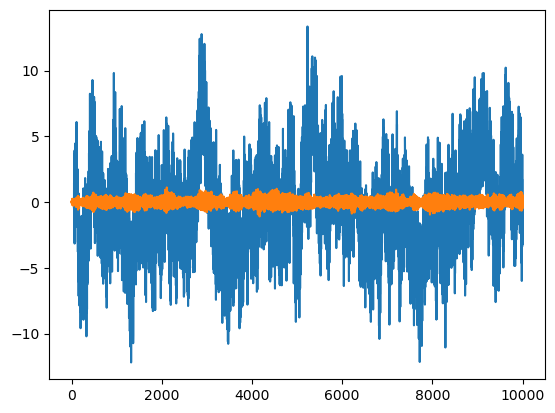

In [28]:
# Creamos simulación Tiempo real (muestra a muestra)

buff_x = np.zeros(L)
estado_y = np.zeros(M-1)
e_n=np.zeros(Ite)
for n in range(Ite):
    #####################################################################################
    buff_x = np.concatenate((buff_x[1:],[x[n]]))  # La red convolucional procesa los datos considerando la muestra más reciente como la última
    ys = model_custom_loss.predict(buff_x.reshape(1,L,1),verbose='False')  #Inferencia de la red
    #####################################################################################
    
    out, estado_y = signal.lfilter(s_rir,1, ys.flatten(), zi = estado_y)  # simulamos propagación acústica
    e_n[n] = d1.flatten()[n] + out  # simulamos suma acústica
plt.plot(d1.flatten())
plt.plot(e_n);

## OPCIÓN 3
- Usamos un modelo basado en una capa oculta de una neurona (otra alternativa para realizar la convolución)
- Redefiniremos la función de pérdidas teniendo en cuenta la propagación como en el ejemplo 2
- Puesto que los predictores repetirán todos los datos menos 1 en cada instancia, para ahorrar memoria definiremos un generador personalizado (aun a riesgo de ralentizar el entrenamiento)

In [30]:
# Definimos el modelo
# Construcción del modelo MLP 

L= 600 # -> Número de pesos del modelo, y número de entradas al modelo

model_MLP = Sequential([
    Dense(1,activation='linear', input_shape=(L,), use_bias=False),  
])

model_MLP.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 600       
                                                                 
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


## Generador personalizado

El generador personalizado definido aquí está diseñado para proporcionar datos en lotes durante el entrenamiento del modelo. Este enfoque es útil cuando se trabaja con conjuntos de datos grandes o cuando se desea optimizar el uso de la memoria.

#### Entrada:

- `X`: El array de datos de entrada (señal original).
- `L`: Longitud de la ventana deslizante, que corresponde al número de pesos o entradas del modelo.
- `p_rir`: Los coeficientes del filtro (respuesta al impulso del sistema de propagación acústica).
- `batch_size`: Número de muestras que se generarán por lote.

#### Salida:

- Genera pares (`x_batch, y_batch`) de datos de entrada y sus correspondientes salidas deseadas en un bucle infinito.

#### Simulación de la Propagación Acústica:

`out = signal.lfilter(p_rir,1,X)`
- La señal de entrada `X` se filtra con el sistema `p_rir` para simular la propagación acústica, generando la salida deseada `out`.

#### Extensión de la Entrada:

`X_ext = np.concatenate((np.zeros(L), X))`
- Se añade un relleno inicial de ceros de longitud `L` a `X` para que la ventana deslizante pueda abarcar las primeras `L` muestras de la señal.

#### Bucle Infinito:

`while True:`

- El generador produce datos indefinidamente, lo cual es ideal para pasar los datos dinámicamente al modelo durante el entrenamiento.

#### Generación de Lotes:

`for start in range(0, len(X_ext) - batch_size + 1, batch_size):`

- Itera sobre la señal extendida `X_ext` en pasos de tamaño `batch_size`, asegurándose de generar suficientes lotes para cubrir toda la señal.

##### Construcción del Lote de Entrada:

`x_batch = np.array([X_ext[start + i + L:start + i:-1] for i in range(batch_size)])`

- Para cada lote, se genera un array de tamaño (`batch_size, L`), donde cada fila es una ventana deslizante invertida de longitud `L`.

#### Construcción del Lote de Salida:

`y_batch = out[start:start + batch_size]`

- La salida deseada se toma directamente de las correspondientes `batch_size` muestras de la señal filtrada `out`.

#### Producción del Lote:

`yield x_batch, y_batch`

- El generador produce un lote de datos de entrada `x_batch` y sus correspondientes salidas `y_batch`.


In [31]:
# Definimos el generador personalizado
def data_generator(X,L,p_rir,batch_size):
    out = signal.lfilter(p_rir,1,X)
    X_ext = np.concatenate((np.zeros(L),X))
    while True:
        for start in range (0,len(X_ext) - batch_size + 1 ,batch_size):
            x_batch = np.array([X_ext[start + i + L:start + i:-1] for i in range(batch_size)])
            y_batch = out[start:start+batch_size]
            yield x_batch, y_batch
        

In [32]:
# Definimos la función de pérdidas personalizada
def custom_loss(S):
    
    M = S.size-1
    # Invertimos los coeficientes para que la convolución se comporte como un filtro lineal 
    filtroinv=np.float32(S[::-1])
    # Expandir dimensiones del filtro para usarlo como kernel en convolución 1D
    filtro_tf = tf.reshape(filtroinv, (-1, 1,1))
     
    
    
    def loss(y_true, y_pred):
        y_pred_tf = tf.reshape(y_pred, (1, -1,1))
        # Filtrado directo mediante convolución 1D
        y_pred_filtered = tf.nn.conv1d(
            y_pred_tf, filters=filtro_tf, stride=1, padding="VALID"
        )

        # Ajustar y_true para que coincida con el tamaño de y_pred_filtered
        
        y_true_cropped = y_true[M:, :]  # Recortar al principio

        # Calcular el MSE entre los targets y la salida filtrada
        mse = tf.reduce_mean(tf.square(y_true_cropped + y_pred_filtered))
        return mse

    return loss

In [33]:
# Aplicamos la función de pérdidas personalizada, compilamos el modelo y preparamos los generadores 
loss_fn = custom_loss(s_rir)
model_MLP.compile(optimizer='adam', loss=loss_fn)
batch_size = 2048 # Fijamos el tamaño del batch. Debe ser mayor que el tamaño del camino secundario para que la fucnción de pérdidas definida no de error

train_gen = data_generator(X_train.flatten(),L,p_rir,batch_size)
val_gen = data_generator(X_val.flatten(),L,p_rir,batch_size)


In [34]:
# Entrenamos el modelo
historia = model_MLP.fit(train_gen, steps_per_epoch=512, epochs=10, validation_data = val_gen, validation_steps=5)

Epoch 1/10
512/512 [==============================] - 5s 9ms/step - loss: 5.9581 - val_loss: 1.0694
Epoch 2/10
512/512 [==============================] - 3s 7ms/step - loss: 0.5918 - val_loss: 0.3418
Epoch 3/10
512/512 [==============================] - 3s 7ms/step - loss: 0.2319 - val_loss: 0.1730
Epoch 4/10
512/512 [==============================] - 4s 7ms/step - loss: 0.1323 - val_loss: 0.1128
Epoch 5/10
512/512 [==============================] - 4s 8ms/step - loss: 0.0948 - val_loss: 0.0720
Epoch 6/10
512/512 [==============================] - 4s 8ms/step - loss: 0.0970 - val_loss: 0.0545
Epoch 7/10
512/512 [==============================] - 4s 8ms/step - loss: 0.0995 - val_loss: 0.0708
Epoch 8/10
512/512 [==============================] - 4s 8ms/step - loss: 0.1106 - val_loss: 0.0538
Epoch 9/10
512/512 [==============================] - 4s 8ms/step - loss: 0.0569 - val_loss: 0.0555
Epoch 10/10
512/512 [==============================] - 4s 8ms/step - loss: 0.0573 - val_loss: 0.0520

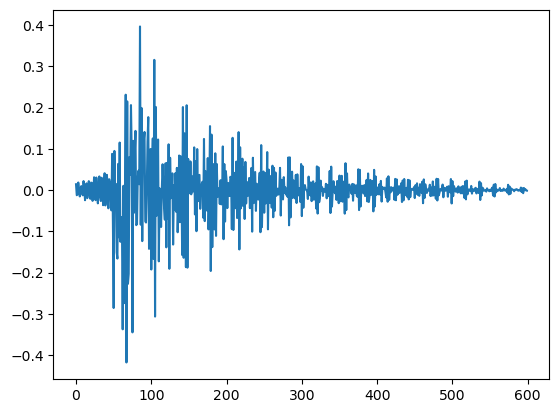

In [35]:
# Visualizamos el modelo que la RN a estimado:
plt.plot(np.array(model_MLP.layers[0].weights)[0,:,0]);

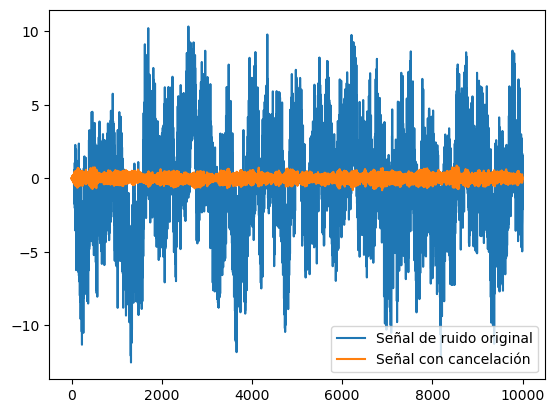

In [36]:
# Comprobamos las prestaciones mediante procesado off-line
Ite=10000  # Número de muestras de ruido (iteraciones, en caso de procesado muestra a muestra, a considerar)
x=np.random.randn(Ite)  # Creamos una señal de referencia
d1 = np.array([signal.lfilter(p_rir,1,x.flatten())])  # Simulamos propagación (obtnemos señal de ruido)


# Calculamos los predictores
xr = np.concatenate((np.zeros(L),x))
x_in = np.array([xr[i + L: i:-1] for i in range(Ite-1)])

y1 = model_MLP.predict(x_in,verbose='False')  # Obtenemos la señal que generaría la RN y reproduciría el altavoz
d1_e = signal.lfilter(s_rir,1,y1.flatten())  # Simulamos la propagación acústica de la señal generada 

plt.plot(d1.flatten()[:-1])   
plt.plot(d1.flatten()[:-1] + d1_e.flatten())  # Simulamos la suma acústica
plt.legend(['Señal de ruido original','Señal con cancelación']);

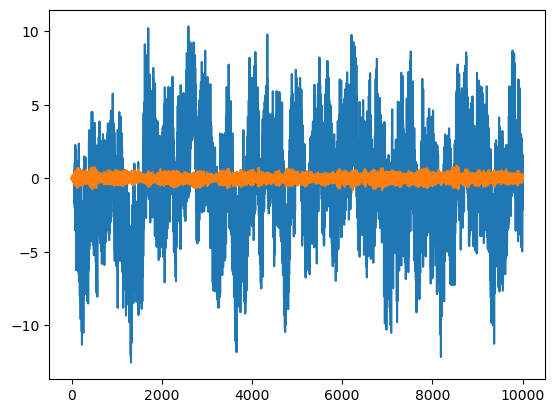

In [37]:
# Creamos simulación Tiempo real (muestra a muestra)

buff_x = np.zeros(L)
estado_y = np.zeros(M-1)
e_n=np.zeros(Ite)

for n in range(Ite):
    #####################################################################################
    buff_x = np.concatenate(([x[n]],buff_x[:-1]))  # La red convolucional procesa los datos considerando la muestra más reciente como la última
    ys = model_MLP.predict(buff_x.reshape(1,L),verbose='False')  #Inferencia de la red
    #####################################################################################

    
    out, estado_y = signal.lfilter(s_rir,1, ys.flatten(), zi = estado_y)  # simulamos propagación acústica
    e_n[n] = d1.flatten()[n] + out  # simulamos suma acústica
plt.plot(d1.flatten())
plt.plot(e_n);